# RNN for Last Name Classification

Welcome to this assignment where you will train a neural network to predict the probable language of origin for a given last name / family name in Latin alphabets.

Throughout this task, you will gain expertise in the following areas:

- Preprocessing raw text data for suitable input into an RNN and (Optionally) LSTM.
- Utilizing PyTorch to train your recurrent neural network models.
- Evaluating your model's performance and making predictions on unseen data.

LSTM is out-of-scope this semester and will not be covered in the exams.


## Download Data

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

## Library imports

Before starting, make sure you have all these libraries.

In [3]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [4]:
%load_ext autoreload
%autoreload 2

## Implement the Neural Network

The main objective of this task is to predict the probability of a given class given a last name, represented as

$$ \Pr ( y | x_1, x_2, x_3, ..., x_i),$$

where $y$ is the category label and each $x_i$ is a character in the last name. Building a basic character-level NLP model has the advantage of understanding how the preprocessing works at a granular level. The character-level network reads words as a sequence of characters, producing a prediction and "hidden state" at each step by feeding its previous hidden state into the next step. The final prediction corresponds to the class to which the word belongs.

All models in PyTorch inherit from the nn.Module subclass. In this assignment, you will **implement a custom model named `RecurrentClassifier`** that runs either [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and define its forward function. The implementation of LSTMs is *optional*.

The forward pass of the model can be visualized with the following diagram:

```
[Embedding] -> [RNN Stack] -> [Extract Last Position] -> [Classifier]
```

- **Embedding:** This component maps each input word (integer) to a vector of real numbers.
    - Input: `[batch_size, seq_len]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **RNN Stack:** This component consists of one or more RNN layers, which process the input sequence of vectors from the Embedding component.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **Extract Last Position:** The RNN Stack component returns a sequence of vectors for each input example. However, for classification purposes, we only need a single vector that captures the full information of the input example. Since the RNN is left-to-right by default, the output state vector at the last position contains the full information of the input example. Therefore, for the $i$-th input example, we extract the output state vector at the last *non-pad* position, which is indicated by `last_pos[i]`.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, rnn_size]`
- **Classifier:** This component is a fully-connected layer that maps the output vectors extracted in the previous step to logits (scores before softmax), which can be used to make predictions about the language of origin for each input example.
    - Input: `[batch_size, rnn_size]`
    - Output: `[batch_size, n_categories]`


These documents would be helpful in this part:

- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
- https://pytorch.org/docs/stable/generated/torch.gather.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [5]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = 'lstm'
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type

        ########################################################################
        # TODO: Create an embedding layer of shape [vocab_size, rnn_size]
        #
        # Hint: Use nn.Embedding
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        # It will map each word into a vector of shape [rnn_size]
        ########################################################################
        self.embedding = nn.Embedding(vocab_size, rnn_size)
        ########################################################################

        ########################################################################
        # TODO: Create a RNN stack with `num_layers` layers with tanh
        #       nonlinearity. Between each layers, there is a dropout of
        #       `dropout`. Implement it with a *single* call to `torch.nn` APIs
        #
        # Hint: See documentations at
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # Set the arguments to call `nn.RNN` such that:
        # - The shape of the input is [batch_size, seq_len, rnn_size]
        # - The shape of the output should be [batch_size, seq_len, rnn_size]
        # Make sure that the dimension ordering is correct. One of the argument
        #   in the constructor of `nn.RNN` (or `nn.LSTM`) is helpful here
        #
        # Optional: Implement one LSTM layer when `model_type` is `lstm`
        ########################################################################
        if model_type == 'lstm':
            # set batch_first means input = (batch_size, seq_len, input_size)
            # no need to pass seq_len as lstm will get it automatically
            self.lstm = nn.LSTM(input_size = rnn_size, hidden_size = rnn_size,
                                num_layers = num_layers, dropout = dropout, batch_first = True)
        elif model_type == 'rnn':
            self.rnn = nn.RNN(input_size = rnn_size, hidden_size = rnn_size,
                              num_layers = num_layers, nonlinearity = "tanh",
                              dropout = dropout, batch_first = True)
        ########################################################################

        ########################################################################
        # TODO: Implement one dropout layer and the fully-connected classifier
        #       layer
        #
        # Hint: We add a dropout layer because neither nn.RNN nor nn.LSTM
        #   implements dropout after the last layer in the stack.
        # Since the input to the classifier is the output of the last position
        #   of the RNN's final layer, it has a shape of [batch_size, rnn_size].
        # The expected output should be logits, which correspond to scores
        #   before applying softmax, and should have a shape of
        #   [batch_size, n_categories].
        ########################################################################
        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(rnn_size, n_categories)
        ########################################################################

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)
        if self.model_type == 'lstm':
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        ########################################################################
        # TODO: Retrieve the output state associated with each sequence
        #
        # Hints:
        # - The output state of all positions is returned by the RNN stack,
        #   but we only need the state in the last position for classification
        #   - The shape of `rnn_out` is [batch_size, seq_len, rnn_size]
        #   - The expected shape of `out` is [batch_size, rnn_size]
        # - For the i-th sequence, we have out[i] == rnn_out[i, last_pos[i]]
        # - Try to condense your code into a single line, without using any
        #   loops. However, if you find it too challenging to do so, you may use
        #   a single layer of for-loop.
        ########################################################################

        batch_size = x.size(0)
        seq_len = x.size(1)
        indices = last_pos.view(batch_size, 1, 1).expand(batch_size, 1, self.rnn_size)  # Expand dimension
        out = rnn_out.gather(1, indices).squeeze(1)
        
        ########################################################################

        out = self.drop(out)
        logits = self.output(out)
        return logits


After completing your implementation, ensure that it passes the following tests. If your implementation fails some tests, but you believe that your implementation is correct, please post the error message along with a brief description on Ed. Please refrain from posting your actual code on Ed.

In [6]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [7]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0',
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

In [8]:
x = torch.arange(20).view(5, 4) % 11
last_pos = torch.tensor([2, 3, 1, 2, 3])
seed = 1025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logits = model(x, last_pos)
print(logits.view(-1)[40:45])
assert logits.shape == torch.Size([5, 17])

'''
assert torch.allclose(
    logits.view(-1)[40:45],
    torch.tensor(
        [
            -0.27393126487731934,
            0.28421181440353394,
            0.2342953234910965,
            0.23580458760261536,
            0.06812290847301483
        ],
        dtype=torch.float
    )
)
'''

model.zero_grad()
logits.sum().backward()
print(model.rnn.weight_hh_l0.grad.view(-1)[40:45])
'''
assert torch.allclose(
    model.rnn.weight_hh_l0.grad.view(-1)[40:45],
    torch.tensor(
        [
            -0.9424352645874023,
            -0.488606333732605,
            0.6905138492584229,
            -0.0017577260732650757,
            1.1024625301361084
        ],
        dtype=torch.float
    )
)
'''

tensor([-0.2739,  0.2842,  0.2343,  0.2358,  0.0681], grad_fn=<SliceBackward0>)
tensor([-0.9424, -0.4886,  0.6905, -0.0018,  1.1025])


'\nassert torch.allclose(\n    model.rnn.weight_hh_l0.grad.view(-1)[40:45],\n    torch.tensor(\n        [\n            -0.9424352645874023,\n            -0.488606333732605,\n            0.6905138492584229,\n            -0.0017577260732650757,\n            1.1024625301361084\n        ],\n        dtype=torch.float\n    )\n)\n'

## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [10]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [11]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [12]:
def letterToIndex(letter):
    ############################################################################
    # TODO: implement the function to map a letter (a character) into its index
    #       in `all_letters`
    #
    # e.g. letterToIndex("a") == 0
    # Don't worry about efficiency here
    ############################################################################
    return all_letters.index(letter)
    ############################################################################

assert letterToIndex("a") == 0
assert letterToIndex("'") == 56

In [13]:
category_lines.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [14]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
print(num_to_cat)
cat_to_num = dict((v,k) for k,v in num_to_cat.items())
print(cat_to_num)

pad = 57 # this is the next available character
vocab_size = 58 # number of characters used in total

{0: 'Arabic', 1: 'Chinese', 2: 'Czech', 3: 'Dutch', 4: 'English', 5: 'French', 6: 'German', 7: 'Greek', 8: 'Irish', 9: 'Italian', 10: 'Japanese', 11: 'Korean', 12: 'Polish', 13: 'Portuguese', 14: 'Russian', 15: 'Scottish', 16: 'Spanish', 17: 'Vietnamese'}
{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}


In [15]:
np.ones(19, dtype=np.int64) * 57

array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57], dtype=int64)

In [16]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [17]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [18]:
data[0]

(array([32, 17, 14,  8, 18, 12,  0, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57], dtype=int64),
 14,
 7)

In [19]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [20]:
len(train_data)

16059

In [21]:
train_data[0]

(array([32, 17, 14,  8, 18, 12,  0, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57], dtype=int64),
 14,
 7)

In [22]:
len(test_data)

4015

In [23]:
test_data[0]

(array([27,  4, 11, 14, 24,  0, 17, 19, 18,  4, 21, 57, 57, 57, 57, 57, 57,
        57, 57], dtype=int64),
 14,
 10)

# Train the model

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

In [24]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [25]:
build_batch(train_data, [1, 2, 3])

(array([[31, 14, 17,  3,  7,  0, 12, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [32, 14, 11, 14,  7,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [26, 12,  4, 19,  8, 18, 19, 14, 21, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57]], dtype=int64),
 array([ 4, 14, 14]),
 array([6, 5, 8]))

**Adjust the hyperparameters listed below** to train an RNN with a minimum evaluation accuracy of 80% after 20 epochs. Your score will be graded on a linear scale, ranging from 0 to the maximum score, as the validation accuracy achieved after the last epoch changes from 70% to 80% (i.e., you get 0 if the accuracy is less than 70%, and get the full score if the accuracy is greater than 80% for this autograding item).

In [26]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())

############################################################################
# TODO: Tune these hyperparameters for a better performance
############################################################################
hidden_size = 32
num_layers = 1
dropout = 0.0
optimizer_class = optim.Adam
lr = 1e-4
batch_size = 256
############################################################################

# Do not change the number of epochs
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [27]:
# Optional
# lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
# lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [28]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [29]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [30]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 59  Loss: 2.77957603931427: 100%|██████████| 63/63 [00:00<00:00, 185.55it/s]  


Epoch: 0  Train Accuracy: 11.91232330780248
Epoch: 0  Eval Accuracy: 24.73225404732254


Epoch: 1  Iteration: 59  Loss: 2.579754614830017: 100%|██████████| 63/63 [00:00<00:00, 473.25it/s] 


Epoch: 1  Train Accuracy: 31.309546048944515
Epoch: 1  Eval Accuracy: 35.2428393524284


Epoch: 2  Iteration: 59  Loss: 2.3747825622558594: 100%|██████████| 63/63 [00:00<00:00, 464.86it/s]


Epoch: 2  Train Accuracy: 38.19042281586649
Epoch: 2  Eval Accuracy: 40.473225404732254


Epoch: 3  Iteration: 59  Loss: 2.142752456665039: 100%|██████████| 63/63 [00:00<00:00, 468.46it/s]


Epoch: 3  Train Accuracy: 44.99034809141291
Epoch: 3  Eval Accuracy: 45.70361145703611


Epoch: 4  Iteration: 59  Loss: 1.905372440814972: 100%|██████████| 63/63 [00:00<00:00, 472.94it/s]


Epoch: 4  Train Accuracy: 47.71156360919111
Epoch: 4  Eval Accuracy: 47.073474470734745


Epoch: 5  Iteration: 59  Loss: 1.7912390232086182: 100%|██████████| 63/63 [00:00<00:00, 489.18it/s]


Epoch: 5  Train Accuracy: 47.79251510056666
Epoch: 5  Eval Accuracy: 47.3225404732254


Epoch: 6  Iteration: 59  Loss: 1.7023853540420533: 100%|██████████| 63/63 [00:00<00:00, 414.25it/s]


Epoch: 6  Train Accuracy: 48.04159661249144
Epoch: 6  Eval Accuracy: 47.72104607721046


Epoch: 7  Iteration: 59  Loss: 1.6512146830558776: 100%|██████████| 63/63 [00:00<00:00, 437.77it/s]


Epoch: 7  Train Accuracy: 49.056603773584904
Epoch: 7  Eval Accuracy: 49.115815691158154


Epoch: 8  Iteration: 59  Loss: 1.591255533695221: 100%|██████████| 63/63 [00:00<00:00, 446.12it/s] 


Epoch: 8  Train Accuracy: 50.495049504950494
Epoch: 8  Eval Accuracy: 50.2615193026152


Epoch: 9  Iteration: 59  Loss: 1.5436719179153442: 100%|██████████| 63/63 [00:00<00:00, 466.36it/s]


Epoch: 9  Train Accuracy: 51.678186686593186
Epoch: 9  Eval Accuracy: 50.90909090909091


Epoch: 10  Iteration: 59  Loss: 1.4651575446128846: 100%|██████████| 63/63 [00:00<00:00, 434.46it/s]


Epoch: 10  Train Accuracy: 52.5811071673205
Epoch: 10  Eval Accuracy: 51.78082191780822


Epoch: 11  Iteration: 59  Loss: 1.4844784259796142: 100%|██████████| 63/63 [00:00<00:00, 404.72it/s]


Epoch: 11  Train Accuracy: 54.03823401208045
Epoch: 11  Eval Accuracy: 53.97260273972603


Epoch: 12  Iteration: 59  Loss: 1.4506823778152467: 100%|██████████| 63/63 [00:00<00:00, 411.01it/s]


Epoch: 12  Train Accuracy: 55.62612865060091
Epoch: 12  Eval Accuracy: 55.342465753424655


Epoch: 13  Iteration: 59  Loss: 1.4293978095054627: 100%|██████████| 63/63 [00:00<00:00, 462.91it/s]


Epoch: 13  Train Accuracy: 56.877763248022916
Epoch: 13  Eval Accuracy: 55.666251556662516


Epoch: 14  Iteration: 59  Loss: 1.410203492641449: 100%|██████████| 63/63 [00:00<00:00, 429.97it/s] 


Epoch: 14  Train Accuracy: 57.39460738526682
Epoch: 14  Eval Accuracy: 56.68742216687422


Epoch: 15  Iteration: 59  Loss: 1.4162867546081543: 100%|██████████| 63/63 [00:00<00:00, 431.80it/s]


Epoch: 15  Train Accuracy: 58.079581543059966
Epoch: 15  Eval Accuracy: 57.359900373599004


Epoch: 16  Iteration: 59  Loss: 1.3556838870048522: 100%|██████████| 63/63 [00:00<00:00, 461.80it/s]


Epoch: 16  Train Accuracy: 58.67737717167943
Epoch: 16  Eval Accuracy: 57.98256537982566


Epoch: 17  Iteration: 59  Loss: 1.3696428894996644: 100%|██████████| 63/63 [00:00<00:00, 443.64it/s]


Epoch: 17  Train Accuracy: 59.11949685534591
Epoch: 17  Eval Accuracy: 58.43088418430884


Epoch: 18  Iteration: 59  Loss: 1.3503025412559508: 100%|██████████| 63/63 [00:00<00:00, 446.38it/s]


Epoch: 18  Train Accuracy: 59.524254312223675
Epoch: 18  Eval Accuracy: 58.92901618929016


Epoch: 19  Iteration: 59  Loss: 1.3224847793579102: 100%|██████████| 63/63 [00:00<00:00, 392.61it/s]

Epoch: 19  Train Accuracy: 60.1095958652469
Epoch: 19  Eval Accuracy: 59.60149439601494


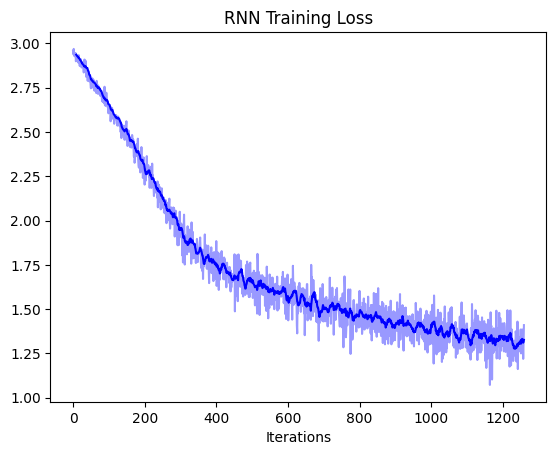

In [31]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

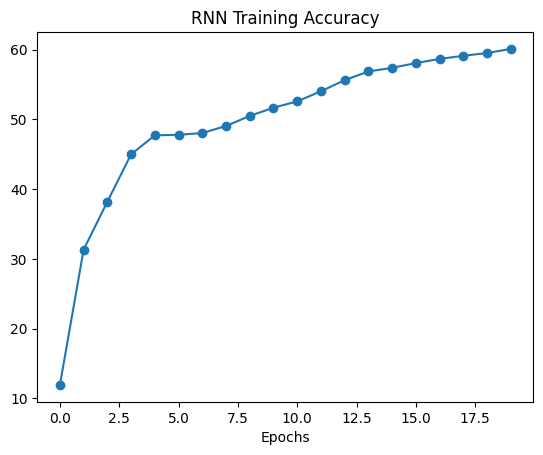

In [32]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

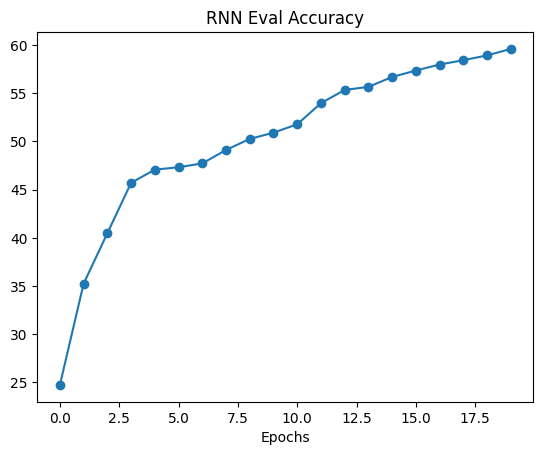

In [33]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [39]:
# Optional
# train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)
train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 59  Loss: 2.9269559383392334: 100%|██████████| 63/63 [00:00<00:00, 187.38it/s]


Epoch: 0  Train Accuracy: 7.665483529485025
Epoch: 0  Eval Accuracy: 8.617683686176838


Epoch: 1  Iteration: 59  Loss: 2.8329697608947755: 100%|██████████| 63/63 [00:00<00:00, 378.12it/s]


Epoch: 1  Train Accuracy: 9.595865246902049
Epoch: 1  Eval Accuracy: 11.481942714819429


Epoch: 2  Iteration: 59  Loss: 2.7042388677597047: 100%|██████████| 63/63 [00:00<00:00, 416.99it/s]


Epoch: 2  Train Accuracy: 17.07453764244349
Epoch: 2  Eval Accuracy: 31.008717310087174


Epoch: 3  Iteration: 59  Loss: 2.490705442428589: 100%|██████████| 63/63 [00:00<00:00, 425.40it/s] 


Epoch: 3  Train Accuracy: 46.58446976773149
Epoch: 3  Eval Accuracy: 52.70236612702366


Epoch: 4  Iteration: 59  Loss: 2.1367154359817504: 100%|██████████| 63/63 [00:00<00:00, 364.05it/s]


Epoch: 4  Train Accuracy: 54.3433588641883
Epoch: 4  Eval Accuracy: 50.48567870485678


Epoch: 5  Iteration: 59  Loss: 1.8587276339530945: 100%|██████████| 63/63 [00:00<00:00, 403.01it/s]


Epoch: 5  Train Accuracy: 49.841210536147955
Epoch: 5  Eval Accuracy: 47.72104607721046


Epoch: 6  Iteration: 59  Loss: 1.7415399074554443: 100%|██████████| 63/63 [00:00<00:00, 415.71it/s]


Epoch: 6  Train Accuracy: 48.869792639641325
Epoch: 6  Eval Accuracy: 47.6214196762142


Epoch: 7  Iteration: 59  Loss: 1.694881761074066: 100%|██████████| 63/63 [00:00<00:00, 396.96it/s] 


Epoch: 7  Train Accuracy: 49.01924154679619
Epoch: 7  Eval Accuracy: 48.61768368617684


Epoch: 8  Iteration: 59  Loss: 1.6283081412315368: 100%|██████████| 63/63 [00:00<00:00, 418.53it/s]


Epoch: 8  Train Accuracy: 50.35805467339187
Epoch: 8  Eval Accuracy: 50.41095890410959


Epoch: 9  Iteration: 59  Loss: 1.58501855134964: 100%|██████████| 63/63 [00:00<00:00, 368.12it/s]  


Epoch: 9  Train Accuracy: 52.39429603337692
Epoch: 9  Eval Accuracy: 52.20423412204234


Epoch: 10  Iteration: 59  Loss: 1.518645131587982: 100%|██████████| 63/63 [00:00<00:00, 430.10it/s] 


Epoch: 10  Train Accuracy: 54.100504390061644
Epoch: 10  Eval Accuracy: 54.371108343711086


Epoch: 11  Iteration: 59  Loss: 1.5191312432289124: 100%|██████████| 63/63 [00:00<00:00, 413.88it/s]


Epoch: 11  Train Accuracy: 55.756896444361416
Epoch: 11  Eval Accuracy: 55.41718555417185


Epoch: 12  Iteration: 59  Loss: 1.4798121690750121: 100%|██████████| 63/63 [00:00<00:00, 387.90it/s]


Epoch: 12  Train Accuracy: 56.877763248022916
Epoch: 12  Eval Accuracy: 56.23910336239103


Epoch: 13  Iteration: 59  Loss: 1.4610894083976746: 100%|██████████| 63/63 [00:00<00:00, 421.15it/s]


Epoch: 13  Train Accuracy: 57.93635967370322
Epoch: 13  Eval Accuracy: 57.011207970112075


Epoch: 14  Iteration: 59  Loss: 1.4355787754058837: 100%|██████████| 63/63 [00:00<00:00, 376.85it/s]


Epoch: 14  Train Accuracy: 58.86418830562301
Epoch: 14  Eval Accuracy: 57.733499377334994


Epoch: 15  Iteration: 59  Loss: 1.4491735458374024: 100%|██████████| 63/63 [00:00<00:00, 336.21it/s]


Epoch: 15  Train Accuracy: 59.4059405940594
Epoch: 15  Eval Accuracy: 58.85429638854296


Epoch: 16  Iteration: 59  Loss: 1.3787118673324585: 100%|██████████| 63/63 [00:00<00:00, 409.06it/s]


Epoch: 16  Train Accuracy: 60.20300143221869
Epoch: 16  Eval Accuracy: 59.25280199252801


Epoch: 17  Iteration: 59  Loss: 1.3951202988624574: 100%|██████████| 63/63 [00:00<00:00, 385.99it/s]


Epoch: 17  Train Accuracy: 60.59530481350022
Epoch: 17  Eval Accuracy: 60.0


Epoch: 18  Iteration: 59  Loss: 1.373247468471527: 100%|██████████| 63/63 [00:00<00:00, 348.91it/s] 


Epoch: 18  Train Accuracy: 61.05610561056105
Epoch: 18  Eval Accuracy: 60.17434620174347


Epoch: 19  Iteration: 59  Loss: 1.3536665201187135: 100%|██████████| 63/63 [00:00<00:00, 361.78it/s]

Epoch: 19  Train Accuracy: 61.535587521016254
Epoch: 19  Eval Accuracy: 60.672478206724776


{'history': {'train_losses': [2.9838554859161377,
   2.995596408843994,
   2.993826150894165,
   2.9823570251464844,
   2.9711856842041016,
   2.980523109436035,
   2.984727382659912,
   2.9988763332366943,
   2.978219747543335,
   3.0021936893463135,
   2.9665725231170654,
   2.979062080383301,
   2.9606528282165527,
   2.9573400020599365,
   2.9761250019073486,
   2.994560956954956,
   2.9513099193573,
   2.9668731689453125,
   2.9591281414031982,
   2.969749689102173,
   2.9669249057769775,
   2.949038505554199,
   2.9685211181640625,
   2.9767143726348877,
   2.961106061935425,
   2.9555459022521973,
   2.981281042098999,
   2.9576828479766846,
   2.9633679389953613,
   2.9605469703674316,
   2.971752166748047,
   2.9555351734161377,
   2.958658218383789,
   2.9461753368377686,
   2.9169600009918213,
   2.960306167602539,
   2.9430618286132812,
   2.9374594688415527,
   2.9467966556549072,
   2.929957389831543,
   2.9347293376922607,
   2.945002794265747,
   2.940753221511841,
   2

## Use Your RNN: Try Your Own Name

Attempt to use the code cells below to **predict the origin of your own last name**.

Please refrain from entering the last names of your classmates, as the names you enter will be logged for anti-plagiarism purposes.

In [40]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [45]:
model = rnn_model
model.eval()
model.cpu()
############################################################################
# TODO: Enter your last name
############################################################################
name = "Chen"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Chen
[28  7  4 13 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
English


In [49]:
model = lstm_model
model.eval()
model.cpu()
############################################################################
# TODO: Enter your last name
############################################################################
name = "Chen"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Chen
[28  7  4 13 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
English


### Question

Although the neural network you have trained is intended to predict the language of origin for a given last name, it could potentially be misused. **In what ways do you think this could be problematic in real-world applications?** Include your answer in your submission of the written assignment.